This code demonstrates the 'calibration' of NMR data using slug tests from boreholes. The slug tests are used to estimate the K at the screened interval of the bores and we use these K values to estimate an optimal constant for the two equations.

Neil Symington

neil.symington@ga.gov.au

In [96]:
%matplotlib inline

In [97]:
from sqlite3 import dbapi2 as sqlite
import pandas as pd
import fiona
from shapely.geometry import Polygon, shape
from shapely import wkt
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import matplotlib.pyplot as plt
import os
import math
import sqlalchemy as db
from sqlalchemy import create_engine, event
import netCDF4
import yaml
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
from hydrogeol_utils.db_utils import makeCon, closeCon

In [98]:
def resample_categorical_intervals(df, parameter_columns,
                                   interval_columns, new_intervals):
    # If the parameter input is a string and not a list make it a list
    if isinstance(parameter_columns, ("".__class__, u"".__class__)):
        parameter_columns = [parameter_columns]
    
    # Create a dataframe to add to
    df_resampled = pd.DataFrame(columns = interval_columns, data = new_intervals)
    
    for p in parameter_columns:
        
        df_resampled[p] = ''
        
        # Iterate through the new intervals
        for i, interval in enumerate(new_intervals):
            
            new_depth_from = interval[0]
            new_depth_to = interval[1]

            mask = (df[interval_columns[0]] < new_depth_to) & (df[interval_columns[1]] > new_depth_from)
            
            v = df[mask][p].mode()
            
            if len(v) == 1:
                
                df_resampled.at[i, p] = v.values[0]
            
            elif len(v) > 1:

                df_resampled.at[i, p] = 'transition'
    
    return df_resampled

In [112]:
# This function extracts the K profile using the SDR equation

def SDR_K(df, N = 1, C = 4000):
    '''
    df: dataframe containing GMR inversion data
    N: empirical exponent for water content when estimating the water content
    C: empirical constant for estimating water content
    '''
    
    return C * np.power(df['Total_water_content'].values, N) * np.square(df['T2'].values)

def objective_function(df, C, N, equation= 'SDR'):
    if equation == 'SDR':
        # Find an estimate of log10 K
        df['bNMR_logK'] = np.log10(SDR_K(df, N = N, C = C))

    # Retrun the sum of the squares
    return (((df['bNMR_logK'] - df['log_K'])**2).sum())

In [101]:
# First import the slug test data

infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\slug_test\compiledSlugtestResults_Keep.xlsx"

df_slugs = pd.read_excel(infile)

In [102]:
# In lieau of a better approach we will average the log of the hydraulic conductivity for each
# bore

df_slugs['log_K'] = np.log10(df_slugs['K estimate (m/day)'].values)

df_logK = df_slugs.groupby(['borehole_id']).mean()[['log_K']]



In [103]:
# Now we want to know the screened interval and other spatial information so we open up the 
# borehole database

path = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite"

DB_PATH = os.path.join(path, "East_Kimberley_borehole_data.sqlite")

SPATIALITE_PATH = r'C:\mod_spatialite-4.3.0a-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = makeCon(DB_PATH)

Connected to \\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite\East_Kimberley_borehole_data.sqlite. Temporary working copy created.


In [104]:
cols = ['Easting','Northing', 'Ground_elevation_mAHD', 'borehole_id']

df_header = borehole_utils.extract_sql_with_primary_key("borehole", cols,  connection, df_logK.index,
                                                        verbose = True)
cols = ['Depth_from','Depth_to', 'Construction_name', 'borehole_id']

df_construction = borehole_utils.extract_sql_with_primary_key('borehole_construction', cols, connection, df_logK.index,
                                                        verbose = True)
# Only keep the screened interval

df_construction = df_construction[df_construction['Construction_name'] == 'screen']

df_merged = df_logK.merge(df_header, on = 'borehole_id').merge(df_construction, on = 'borehole_id')


select t.Easting, t.Northing, t.Ground_elevation_mAHD, t.borehole_id from borehole t where t.borehole_id in (635728,635732,635733,635734,635735,635736,635737,635738,635739,635740,635741,635742,635743,635745,635921);
select t.Depth_from, t.Depth_to, t.Construction_name, t.borehole_id from borehole_construction t where t.borehole_id in (635728,635732,635733,635734,635735,635736,635737,635738,635739,635740,635741,635742,635743,635745,635921);


In [105]:
# Now we want to find the stratigraphy at each hole

infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\stratigraphy\EK_SonicStratigraphySummary.csv"

df_interp = pd.read_csv(infile)

# Add a stratigraphy column
df_merged['stratigraphy'] = ''

for index, row in df_merged.iterrows():
    
    new_intervals = pd.DataFrame(columns = ['Depth_from', 'Depth_to'],
                                 data = np.array([[row.Depth_from, row.Depth_to]]))
    
    # Subset the interpreted dataframe
    eno = row.borehole_id
    
    # Get the stratigraphy for the borehole
    df_strat_subset = borehole_utils.extract_by_primary_key(df_interp, eno)
    
    # If stratigraphy data exists then get it for this interval
    
    if df_strat_subset is not None:
        strat = resample_categorical_intervals(df_strat_subset, ['stratigraphy'],
                                       ['Depth_from', 'Depth_to'], new_intervals.values)['stratigraphy'].values[0]
    # Otherwise I am assured it is in the Permo-Carboniferous
    else:
        strat = 'Permo-Carboniferous'
    
    df_merged.at[index, 'stratigraphy'] = strat

In [106]:
# Get the bNMR

cols = ['Depth', 'Total_water_content','Clay_water_content', 'Capillary_water_content',
        'Free_water_content', 'T2', 'borehole_id']

df_bNMR = borehole_utils.extract_sql_with_primary_key("boreholeNMR_data", cols, connection, df_logK.index,
                                                verbose = True)

select t.Depth, t.Total_water_content, t.Clay_water_content, t.Capillary_water_content, t.Free_water_content, t.T2, t.borehole_id from boreholeNMR_data t where t.borehole_id in (635728,635732,635733,635734,635735,635736,635737,635738,635739,635740,635741,635742,635743,635745,635921);


In [107]:
# For each bore with slug test results we will find all of the javelin observations
# for the screened interval and average them and add them to the merge dataframe

# Define the columns to add to the dataframe
cols = ['Total_water_content', 'Clay_water_content',
       'Capillary_water_content', 'Free_water_content', 'T2']

for c in cols:
    df_merged[c] = np.nan

for index, row in df_merged.iterrows():
    
    # Subset the interpreted dataframe
    eno = row.borehole_id
    
    # Get the stratigraphy for the borehole and average
    df_bNMR_subset = borehole_utils.extract_by_primary_key(df_bNMR, eno).mean()
    
    # Add this to the df_merged dataframe
    df_merged.at[index, cols] = df_bNMR_subset[cols]
    


In [108]:
df_merged

,borehole_id,log_K,Easting,Northing,Ground_elevation_mAHD,Depth_from,Depth_to,Construction_name,stratigraphy,Total_water_content,Clay_water_content,Capillary_water_content,Free_water_content,T2
0,635728,1.789793,520144.760,8306293.880,7.519,31.0,37.0,screen,Cenozoic sediments,0.282634,0.046809,0.115021,0.120803,0.026265
1,635732,0.257649,522411.732,8301368.526,12.030,85.8,91.8,screen,Permo-Carboniferous,0.753343,0.031355,0.042583,0.679405,0.333201
2,635733,1.715435,501830.614,8295403.070,17.506,18.0,24.0,screen,Cenozoic sediments,0.257105,0.046022,0.059689,0.151394,0.095160
3,635734,0.900855,504915.931,8292360.686,17.913,29.0,35.0,screen,Cenozoic sediments,0.185226,0.059318,0.080693,0.045215,0.017892
4,635735,-0.073194,505309.448,8293856.701,16.494,36.0,42.0,screen,Permo-Carboniferous,0.154501,0.035109,0.055415,0.063977,0.031986
5,635736,2.231647,509392.776,8307934.098,16.490,124.0,130.0,screen,Permo-Carboniferous,0.228254,0.025166,0.043771,0.159317,0.202846
6,635737,0.192111,507769.229,8299897.749,12.462,29.0,35.0,screen,Permo-Carboniferous,0.178222,0.031942,0.062346,0.083934,0.062709
7,635738,0.190813,514309.962,8298828.237,17.673,39.0,45.0,screen,Permo-Carboniferous,0.212899,0.032806,0.099372,0.080720,0.029696
8,635739,2.024478,500051.985,8295681.132,18.799,29.0,35.0,screen,Cenozoic sediments,0.227814,0.064926,0.096159,0.066728,0.025235
9,635740,2.624129,500053.109,8296644.456,18.357,17.0,23.0,screen,Cenozoic sediments,0.202921,0.035262,0.084511,0.083148,0.048137


In [120]:
# Now we have the data we can easily estimate the hydraulic conductivity from 
# for values of C and use this to find the optimal value of C for each formation

formation = "Cenozoic sediments"

df_opt = df_merged[df_merged['stratigraphy'] == formation][['log_K','Total_water_content', 'T2']]

# Scan a number of different C values

C_vals = np.arange(10, 10000, 5)

sum_of_squares = np.nan*np.ones(shape = C_vals.shape)

for i, c in enumerate(C_vals):
    sum_of_squares[i] = objective_function(df_opt, c, 2, equation= 'SDR')



In [121]:
df_opt

,log_K,Total_water_content,T2,bNMR_logK
0,1.789793,0.282634,0.026265,-0.259011
2,1.715435,0.257105,0.095160,0.776918
3,0.900855,0.185226,0.017892,-0.959476
8,2.024478,0.227814,0.025235,-0.481039
9,2.624129,0.202921,0.048137,-0.020600
10,1.991371,0.227412,0.052006,0.145522
11,1.240067,0.209952,0.016366,-0.928107
12,1.595826,0.299494,0.023870,-0.291754
13,2.242708,0.344380,0.013088,-0.692368


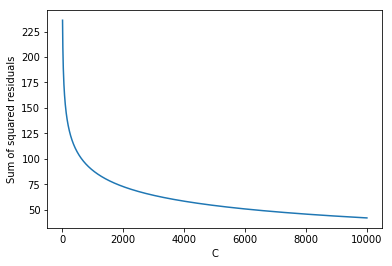

9995


In [122]:
# Explore the results

# Find the C that produces the minimum of the residuals

best_C = C_vals[np.argmin(sum_of_squares)]
plt.close()
plt.plot(C_vals,sum_of_squares)
plt.ylabel('Sum of squared residuals')
plt.xlabel('C')
plt.show()

print(best_C)

In [89]:
C_vals

array([  10,   15,   20,   25,   30,   35,   40,   45,   50,   55,   60,
         65,   70,   75,   80,   85,   90,   95,  100,  105,  110,  115,
        120,  125,  130,  135,  140,  145,  150,  155,  160,  165,  170,
        175,  180,  185,  190,  195,  200,  205,  210,  215,  220,  225,
        230,  235,  240,  245,  250,  255,  260,  265,  270,  275,  280,
        285,  290,  295,  300,  305,  310,  315,  320,  325,  330,  335,
        340,  345,  350,  355,  360,  365,  370,  375,  380,  385,  390,
        395,  400,  405,  410,  415,  420,  425,  430,  435,  440,  445,
        450,  455,  460,  465,  470,  475,  480,  485,  490,  495,  500,
        505,  510,  515,  520,  525,  530,  535,  540,  545,  550,  555,
        560,  565,  570,  575,  580,  585,  590,  595,  600,  605,  610,
        615,  620,  625,  630,  635,  640,  645,  650,  655,  660,  665,
        670,  675,  680,  685,  690,  695,  700,  705,  710,  715,  720,
        725,  730,  735,  740,  745,  750,  755,  7